# Register ROI

Attempt to register all ROIs together using dapi

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
project = "becalia_rabies_barseq"
mouse = "BRAC8498.3e"

to_flip = [('chamber_07', r) for r in [1,2,3,5,6,7,8,  10]]


In [3]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import iss_preprocess as issp
import iss_analysis as issa
from image_tools.similarity_transforms import make_transform, transform_image

In [4]:
from tqdm import tqdm
from skimage.transform import SimilarityTransform, warp


def iterative_tform(images, use_masked_correlation=True, max_shift=100):
    reference = None
    registered = np.zeros_like(images)
    transform_params = []
    for i_img, img in tqdm(enumerate(images), total=len(images)):
        if reference is None:
            reference = img.copy()
            transform_params.append((0, (0,0)))
            registered[i_img] = reference
            continue
        target = img.copy()
        if use_masked_correlation:
            target_mask = target > 0
            reference_mask = reference > 0
        else:
            target_mask = None
            reference_mask = None
        best_angle, shift,db = issp.reg.rounds_and_channels.estimate_rotation_translation(
            reference=reference,
            target=target,
            angle_range=30.0,
            niter=3,
            nangles=25,
            reference_mask=reference_mask,
            target_mask=target_mask,
            upsample=None,
            min_shift=0,
            max_shift=max_shift,
            iter_range_factor=5.0,
            debug=True,
        )
        # the transformed target becomes the new reference
        reference = transform_image(target, scale=1, angle=best_angle, shift=shift)
        registered[i_img] = reference.copy()
        transform_params.append((best_angle, shift))
    return registered, transform_params


In [5]:
# attempt with rabies
error_correction_ds_name="BRAC8498.3e_error_corrected_barcodes_16"
rab_df, rab_cells_barcodes, rab_cells_properties = issa.segment.get_barcode_in_cells(
    project, mouse, error_correction_ds_name, valid_chambers=None, save_folder=None, verbose=True
)

Loaded 698449 rabies barcodes
Getting mask assignments for 4 chambers
Counting spots
Data frame with 24894 rabies cells and 2508 unique barcodes
Done


In [6]:
rab_cells_properties.head()

,x,y,cell_id,roi,chamber,max_n_spots,main_barcode,n_unique_barcodes
mask_uid,,,,,,,,
chamber_07_10_10133,14505.290505,8961.833961,10133,10,chamber_07,3,CGATAGTTGTGCCA,1
chamber_07_10_10269,14284.300007,8932.736226,10269,10,chamber_07,19,CGTAATTAGGGCAT,1
chamber_07_10_10360,14894.134037,8277.534011,10360,10,chamber_07,6,GCAAACCTAGATAC,1
chamber_07_10_10393,14301.303496,8947.733731,10393,10,chamber_07,3,TCACATACTCTGTA,1
chamber_07_10_10562,15168.354292,8447.077775,10562,10,chamber_07,14,CCAGAATTTCAGAG,1


In [7]:
chamber = 'chamber_08'
roi = 4
data_path = f"{project}/{mouse}/{chamber}"
manual_folder = issp.io.get_processed_path(data_path) / 'manual_starter_click'
fname_ds = manual_folder / f"{mouse}_{chamber}_{roi}_reference_ds.tif"
reference = tifffile.imread(fname_ds)
print(reference.shape)

(228, 214)


In [8]:
spots = rab_df[rab_df['cell_mask'] != -1 ].copy()
factor = 40

big_shape = np.array([rab_df.y.max() + factor ,rab_df.x.max() + factor]).astype(int)
print(f"Big shape: {big_shape}")
spots['x'] //= factor
spots['y'] //= factor
small_shape = big_shape // factor
print(f"Small shape: {small_shape}")
roi_list = list(rab_df[['chamber', 'roi']].drop_duplicates().values)
rabies_img_stack = np.zeros((len(roi_list), *small_shape))
for iroi, (c, r) in enumerate(roi_list):
    df = spots[(spots.chamber==c) & (spots.roi==r)].copy()
    if (c,r) in to_flip:
        assert np.all(df['y'] < small_shape[0])
        df['y'] = small_shape[0] - df['y']
    img = issp.segment.spots.make_spot_image(df, gaussian_width=5, dtype="single", output_shape=small_shape)
    rabies_img_stack[iroi] = img

Big shape: [27007 23139]
Small shape: [675 578]


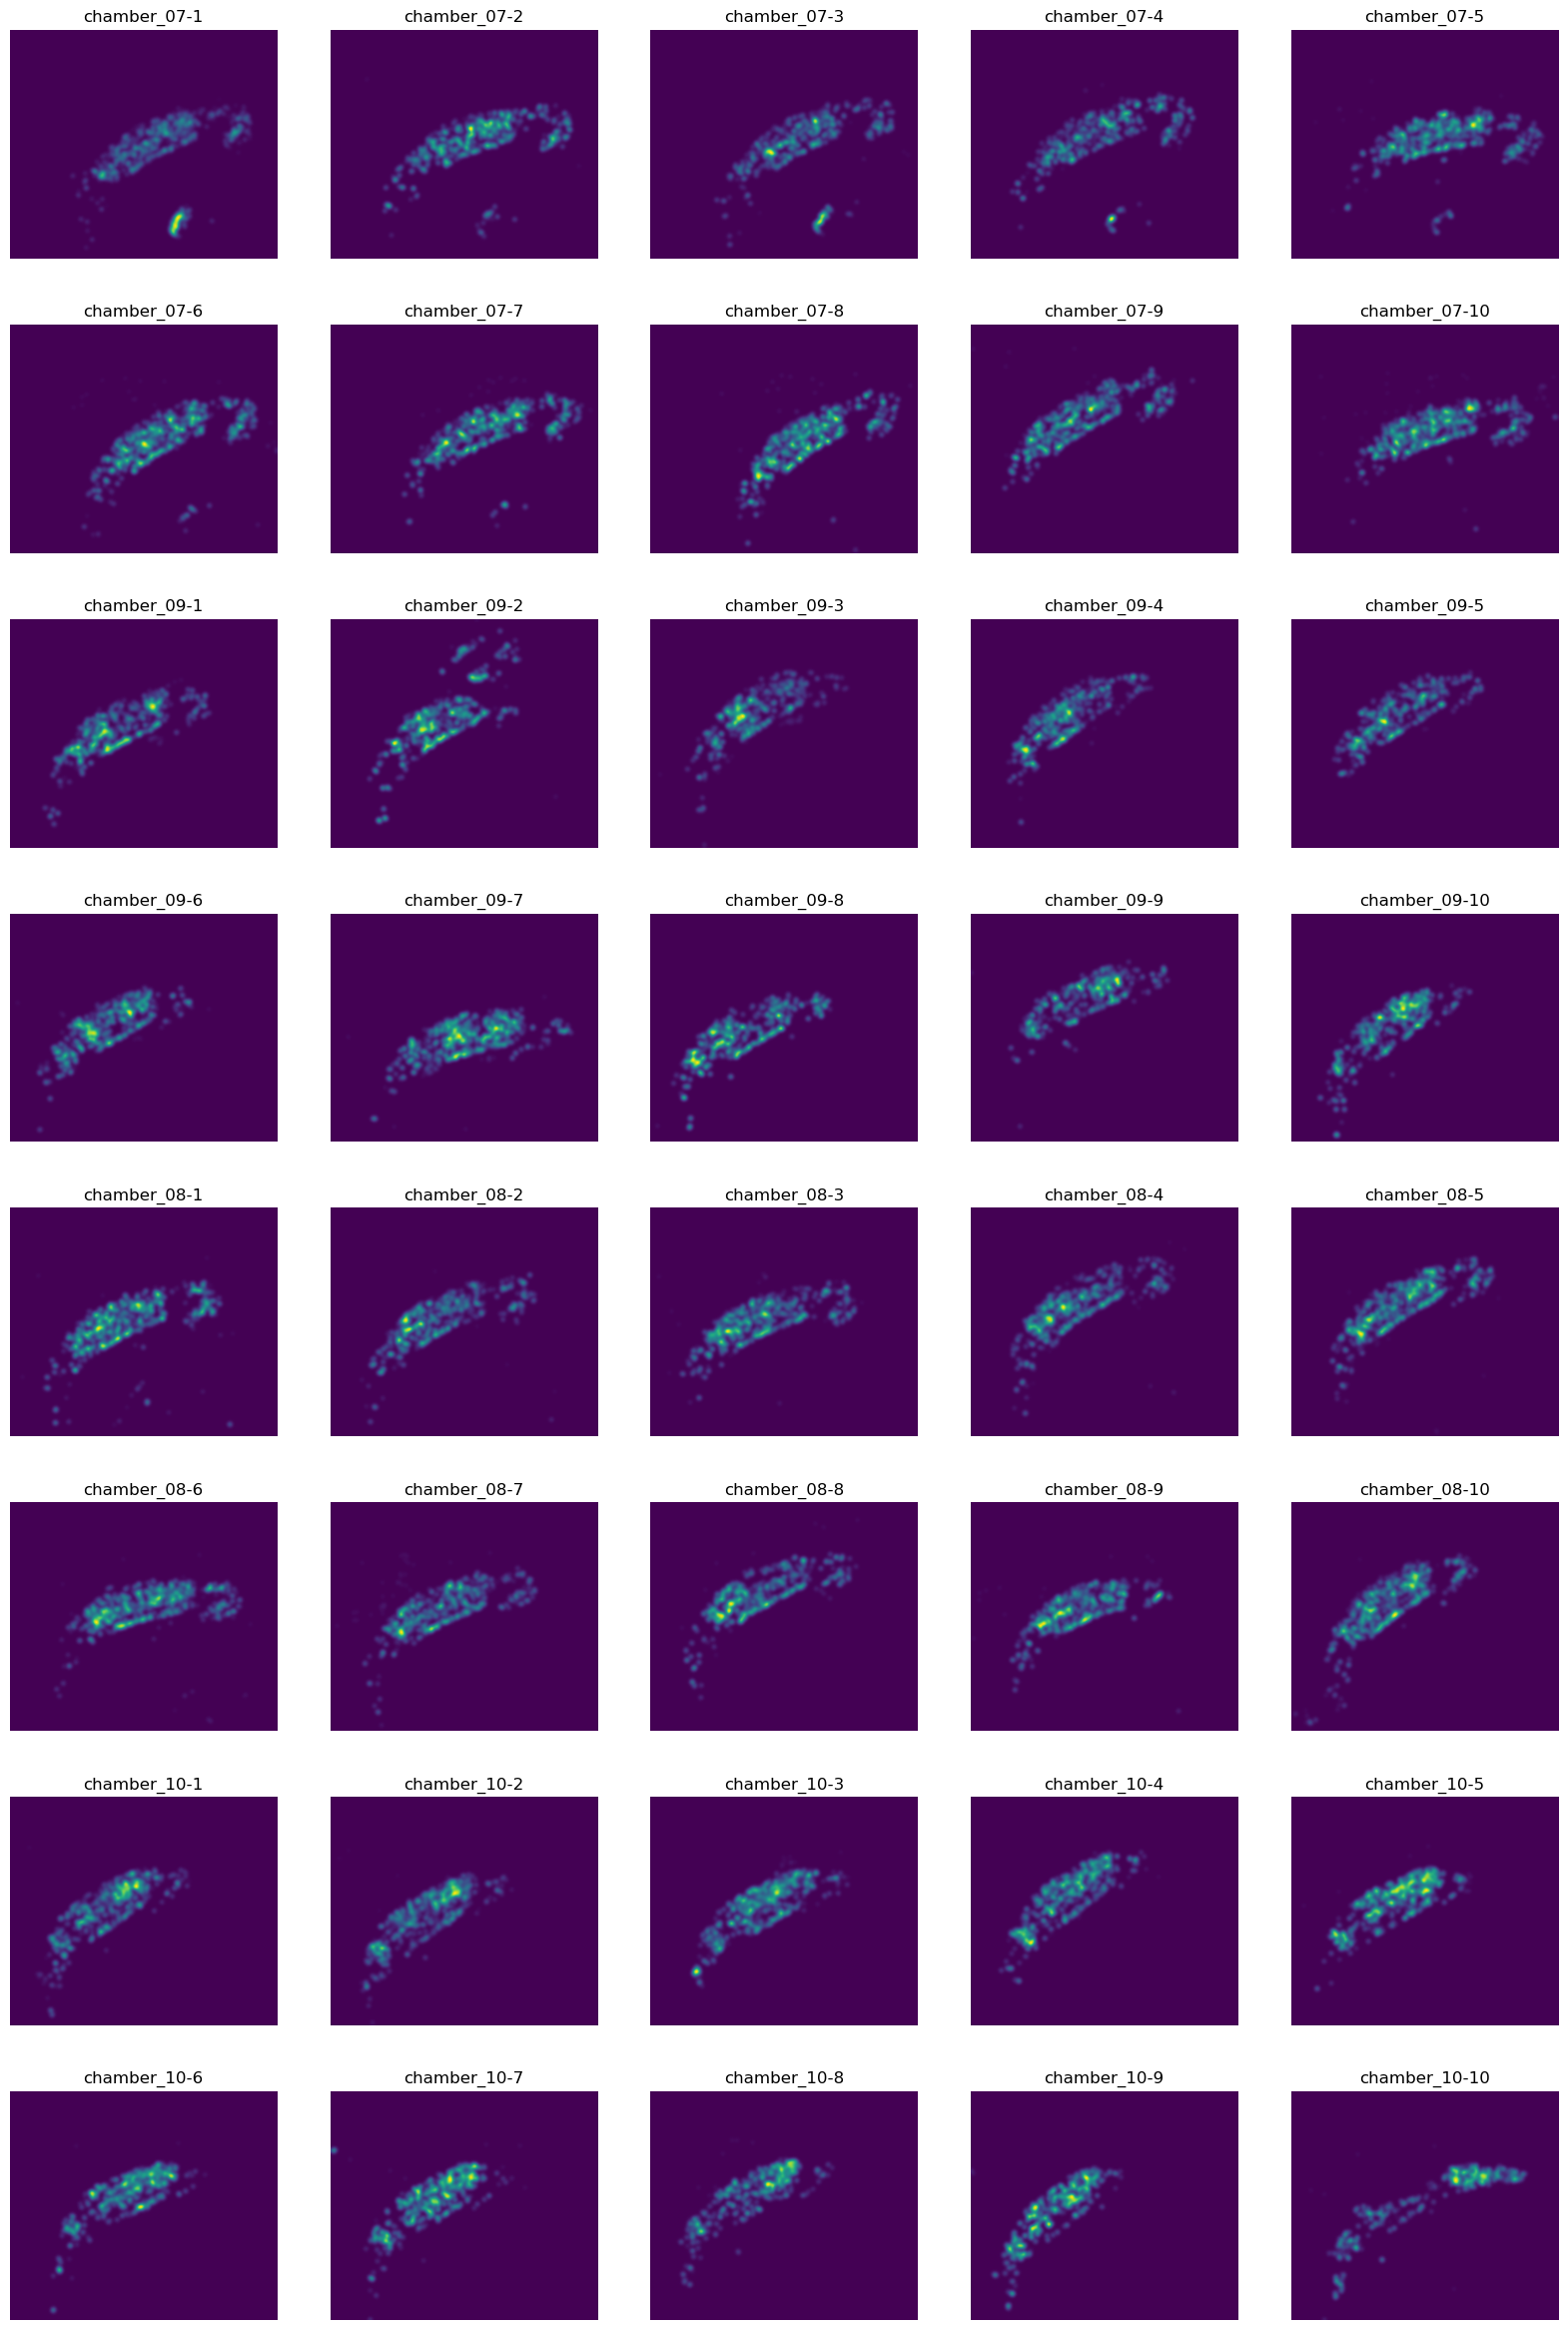

In [9]:
fig, axes = plt.subplots(8,5, figsize=(20,30))

for i, (r,c) in enumerate(roi_list):
    ax = axes.flatten()[i]
    ax.imshow(rabies_img_stack[i].T, origin='lower')
    ax.set_title(f"{r}-{c}")
    ax.set_axis_off()

In [10]:
redo = False
target_path = issp.io.get_processed_path(f"{project}/{mouse}") / f'registered_stack_from_rabies.tif'
tf_file = issp.io.get_processed_path(f"{project}/{mouse}") / "tforms_from_rabies.npy"
if not redo and target_path.exists():
    registered = tifffile.imread(target_path)
    transform_params = np.load(tf_file)
else:
    registered, transform_params = iterative_tform(rabies_img_stack, use_masked_correlation=True, max_shift=small_shape[0]//10)
    tifffile.imwrite(target_path, registered)
    transform_params = np.vstack([np.hstack(t) for t in transform_params])
    np.save(tf_file, transform_params)


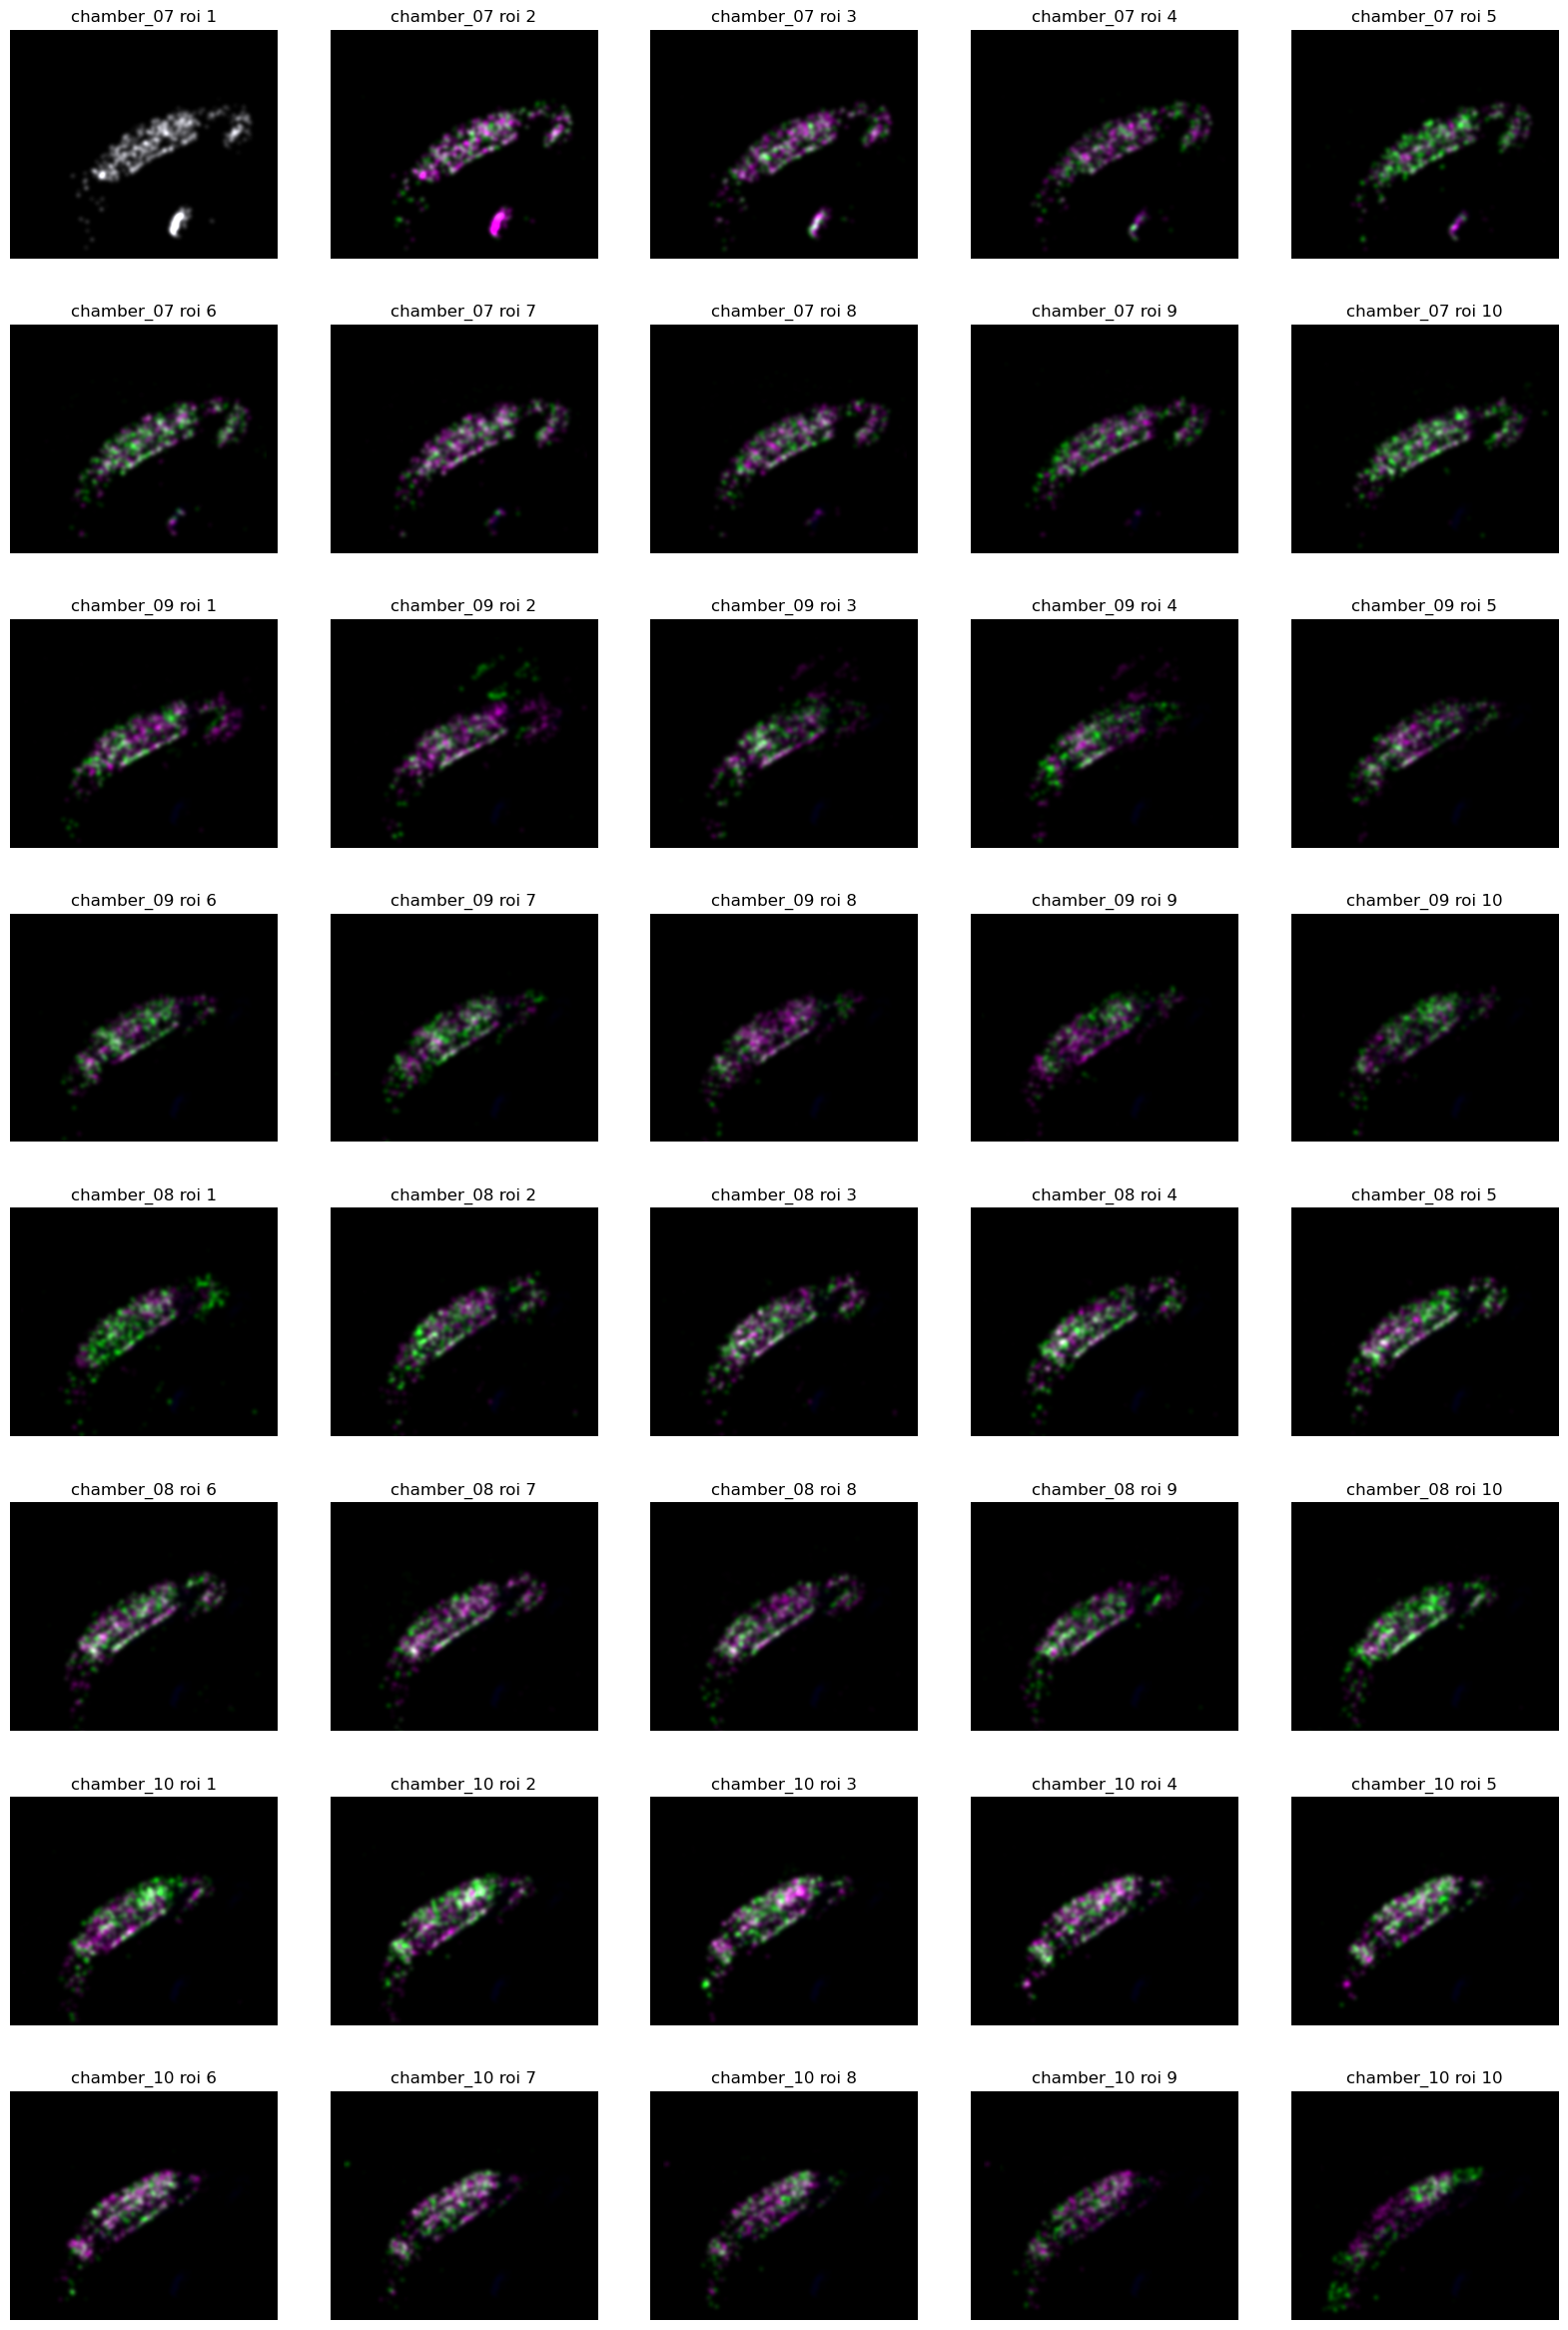

In [11]:
fig, axes = plt.subplots(8, 5, figsize=(20, 30))
iax = 0
which = registered
for iroi, (chamber, roi) in enumerate(roi_list):
    ax = axes.flatten()[iroi]
    if not iroi:
        ref = which[iroi]
    elif iroi == 1:
        ref = which[iroi-1]
    else:
        ref = np.mean(which[[iroi-2, iroi-1]], axis=0)

    st = np.dstack([ref.T, which[iroi].T, rabies_img_stack[0].T])
    rgb = issp.vis.to_rgb(st, colors=[(1,0,1), (0,1,0), (0,0,1)], vmax=[50, 50, 1000], vmin=[0]*3)
    ax.imshow(rgb, origin='lower')
    iax += 1
    ax.set_title(f"{chamber} roi {roi}")

for iax, x in enumerate(axes.flatten()):
    x.set_aspect('equal')
    x.set_axis_off()
 



In [12]:
# make a registered version of dapi image
from skimage.transform import rescale
valid_chambers = ['chamber_07', 'chamber_08', 'chamber_09', 'chamber_10']
dapi_reg = np.zeros_like(registered)
for iroi, (chamber, roi) in enumerate(roi_list):
    data_path = f"{project}/{mouse}/{chamber}"
    manual_folder = issp.io.get_processed_path(data_path) / 'manual_starter_click'

    fname_ds = manual_folder / f"{mouse}_{chamber}_{roi}_reference_ds.tif"
    reference = tifffile.imread(fname_ds)
    scale_diff = 100/factor

    reference = rescale(reference, scale_diff)

    reference = reference[:small_shape[0], :small_shape[1]]
    # 0-pad if necessary
    if reference.shape[0] < small_shape[0]:
        reference = np.pad(reference, ((0, small_shape[0]-reference.shape[0]), (0,0)))
    if reference.shape[1] < small_shape[1]:
        reference = np.pad(reference, ((0,0), (0, small_shape[1]-reference.shape[1])))
    if (chamber, roi) in to_flip:
        reference = reference[::-1]
    dapi_reg[iroi]  = transform_image(reference, scale=1, angle=transform_params[iroi,0], shift=transform_params[iroi,1:])

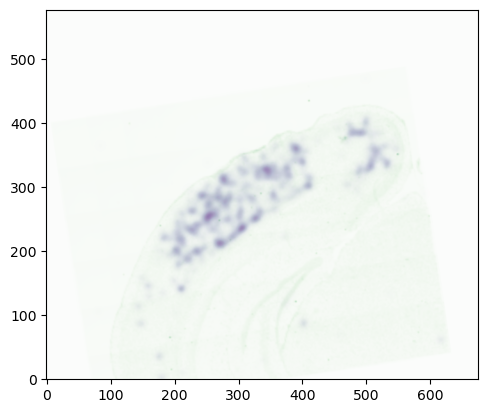

In [13]:
iroi = 20
plt.imshow(dapi_reg[iroi].T, origin='lower', alpha=0.5, cmap='Greens')
plt.imshow(registered[iroi].T, origin='lower', alpha=0.5, cmap='Purples')


# Apply full tform on barcode spots

In [14]:
min_n_rol = 5
min_n_presy = 5

# Load rabies data

error_correction_ds_name="BRAC8498.3e_error_corrected_barcodes_16"
rab_df, rab_cells_barcodes, rab_cells_properties = issa.segment.get_barcode_in_cells(
    project, mouse, error_correction_ds_name, valid_chambers=None, save_folder=None, verbose=False
)
starters_positions = issa.io.get_starter_cells(project, mouse, verbose=False)
rabies_cell_properties = issa.segment.match_starter_to_barcodes(project, mouse, rab_cells_properties, rab_df, starters=starters_positions, redo=False, verbose=False)
starter_properties = rab_cells_properties[rab_cells_properties['starter']]
starter_barcodes = rab_cells_barcodes.loc[starter_properties.index]
print(f"Clicked {len(starter_properties)} starter cells")

# filter starter with not enough rolonies
starter_properties = starter_properties[starter_properties.max_n_spots > min_n_rol].copy()
starter_barcodes = starter_barcodes.loc[starter_properties.index].copy()
print(f"Kept {len(starter_properties)} starter cells with > {min_n_rol} rolonies")

# filter barcodes with multiple starters
n_starter_per_barcode = (starter_barcodes.values > 0).sum(axis=0)
valid_barcodes = starter_barcodes.columns[n_starter_per_barcode == 1]
n_cell_per_barcode = (rab_cells_barcodes > 0).sum(axis=0)
example_barcodes = valid_barcodes[(n_cell_per_barcode.loc[valid_barcodes] > min_n_presy)]
print(f"Found {len(example_barcodes)} example barcodes with at least {min_n_presy} presynaptic cells")


Done
Clicked 570 starter cells
Kept 444 starter cells with > 5 rolonies
Found 264 example barcodes with at least 5 presynaptic cells


In [15]:
example_starters_barcodes = starter_barcodes[starter_barcodes[example_barcodes].any(axis=1)]
example_starters_properties = rab_cells_properties.loc[example_starters_barcodes.index]
example_starters_barcodes.head()

corrected_bases,AAAAAAAAAATGTA,AAAAAAAAGACGTC,AAAAAAAATGTATT,AAAAAACTCATCGA,AAAAAACTCCGGTT,AAAAACGGGTTACG,AAAAATCCGCCGAA,AAAACATACACAGG,AAAACTGACTGATA,AAAAGACATCAAAG,...,TTTTCTTCGTCCAT,TTTTGCACAAGGTA,TTTTGCTATGATTC,TTTTGGACCTTTAT,TTTTGTCCACATCA,TTTTTACCACGAGC,TTTTTCACTCATCA,TTTTTCGCCTCGAA,TTTTTGGATTGCGG,TTTTTGTTTGACCC
mask_uid,,,,,,,,,,,,,,,,,,,,,
chamber_07_10_10939,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chamber_07_10_10983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chamber_07_10_11919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chamber_07_10_13598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chamber_07_10_13631,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:

rab_cells_properties['x_reg'] = np.nan
rab_cells_properties['y_reg'] = np.nan
rab_df['x_reg'] = np.nan
rab_df['y_reg'] = np.nan

def flip_spot(spots, shape):
    spots[:,1]= shape[0] - spots[:,1]
    return spots

for iroi, (c, r) in enumerate(roi_list):
    df = rab_df[(rab_df.chamber==c) & (rab_df.roi==r)]
    params = transform_params[iroi]
    data_path = f"{project}/{mouse}/{c}"
    #tile_corners = issp.pipeline.stitch.get_tile_corners(data_path, 'hybridisation_round_2_1', r)
    shape = big_shape #tile_corners.max(axis=(0,1,3)).astype(int)
    sp = df.loc[:, ['x', 'y']].values
    if (c, r) in to_flip:
        sp = flip_spot(sp, shape)
    # make into homogeneous coordinates
    spots_tform = make_transform(s=1, angle=params[0], shift=(params[1:]* factor), shape=shape)
    transformed_coors = spots_tform @ np.pad(sp, [(0,0), (0, 1)], mode='constant', constant_values=1).T
    rab_df.loc[df.index, 'x_reg'] = [x for x in transformed_coors[0, :]]
    rab_df.loc[df.index, 'y_reg'] = [y for y in transformed_coors[1, :]]

    # same for cell centroids
    centr_df = rab_cells_properties[(rab_cells_properties.chamber == c) & (rab_cells_properties.roi == r)]
    centr = centr_df[['x', 'y']].values
    if (c, r) in to_flip:
        centr = flip_spot(centr, shape)
    transformed_coors = spots_tform @ np.pad(centr, [(0,0), (0,1)], mode='constant', constant_values=1).T
    
    rab_cells_properties.loc[centr_df.index, 'x_reg'] = [x for x in transformed_coors[0, :]]
    rab_cells_properties.loc[centr_df.index, 'y_reg'] = [x for x in transformed_coors[1, :]]


In [18]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 

Starter cell chamber_07_9_30230 with barcode GCCATACTGTAAAA in roi 9 or chamber chamber_07
Starter cell chamber_08_8_15913 with barcode TGTACCGTCTATGC in roi 8 or chamber chamber_08
Starter cell chamber_08_9_10303 with barcode TACTATCTCGATAT in roi 9 or chamber chamber_08
Starter cell chamber_08_6_12087 with barcode TGTCACTTGCATCC in roi 6 or chamber chamber_08
/nemo/project/proj-znamenp-barseq/processed/becalia_rabies_barseq/BRAC8498.3e/analysis/rabies_overlay_with_brain.pdf


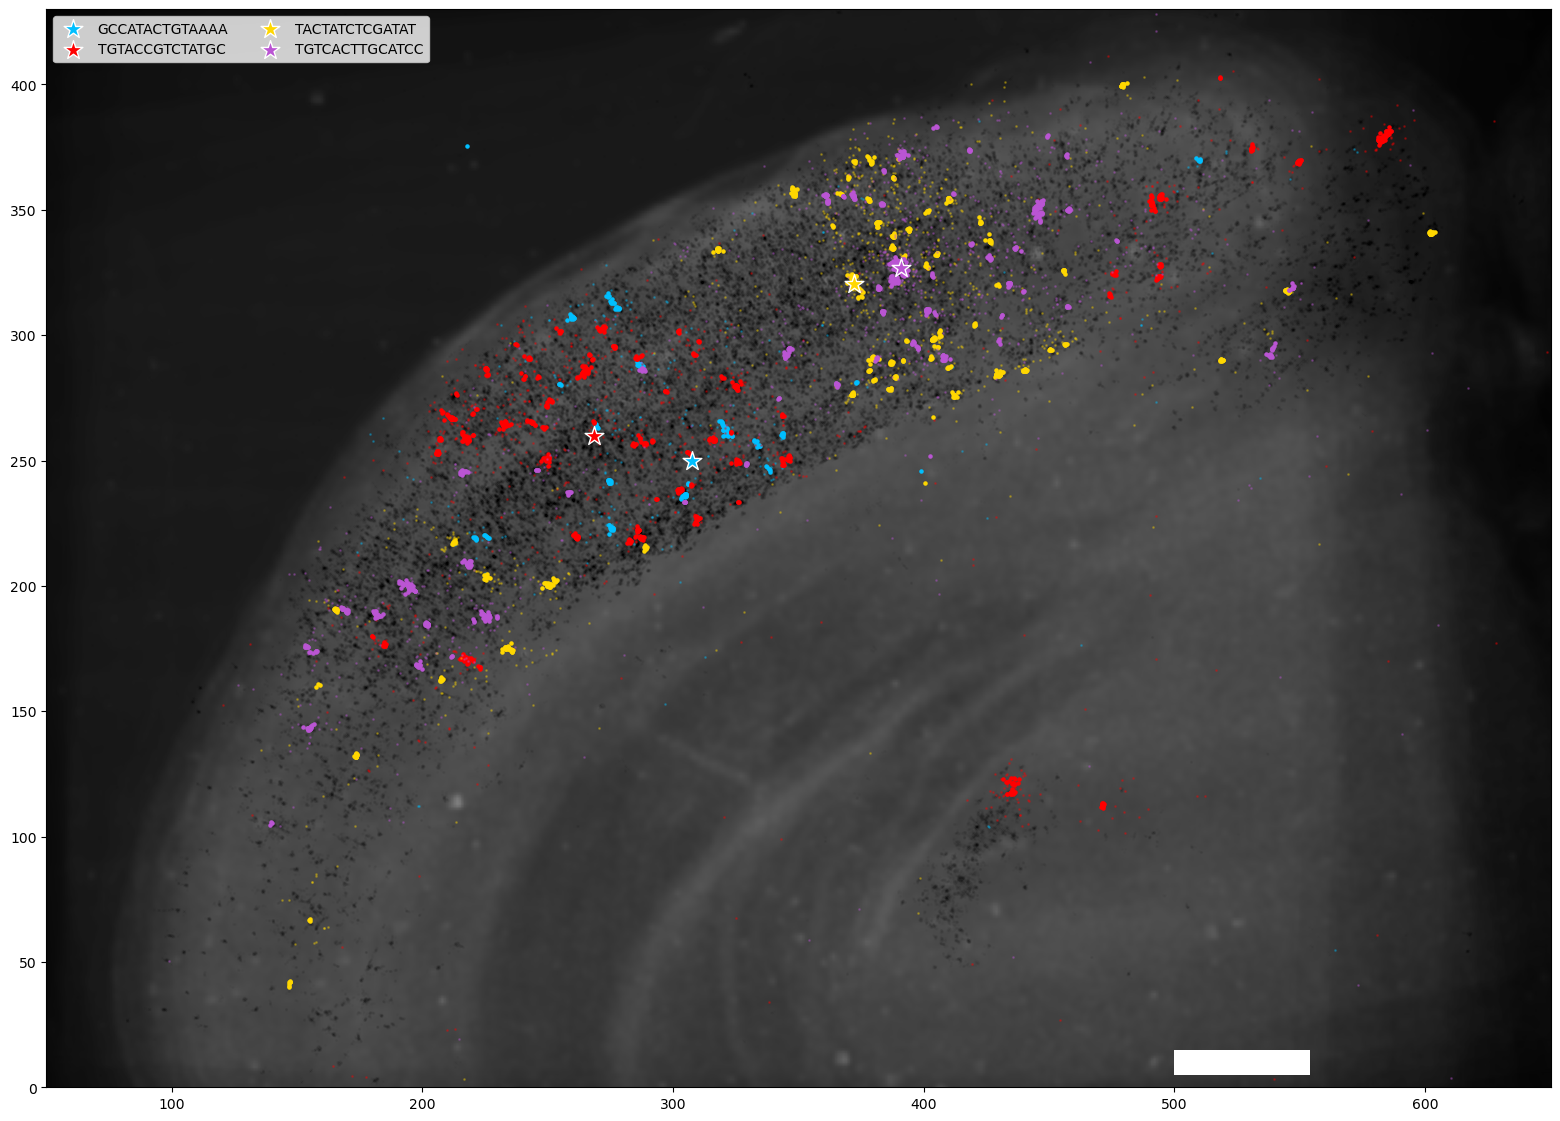

In [19]:
# overlay version
import matplotlib.cm as cm
add_brain=True

bad = [('chamber_09', 2)]

rab_df_part = rab_df# [~((rab_df.chamber == bad[0][0]) & (rab_df.roi == bad[0][1]))]


fig = plt.figure(figsize=(20,14))
ax = plt.subplot(111, aspect='equal')
ax.set_facecolor('k')

# plot background spots of that roi
# plt.imshow(registered.sum(axis=0))
if add_brain:
    #plt.imshow(registered[:20].sum(axis=0).T, cmap='gray', origin='lower')
    plt.imshow(dapi_reg.sum(axis=0).T, cmap='gray', origin='lower', alpha=0.5)
    # plt.imshow(dapi_reg[15].T, cmap='gray', origin='lower', alpha=0.5)

bg = rab_df_part[(rab_df_part.cell_mask != -1)] # (rab_df.chamber == st_c) & (rab_df.roi == st_r) & 
plt.scatter(bg.y_reg/factor, bg.x_reg/factor, color='k' if add_brain else 'w', alpha=0.03, marker='.', s=1)
    
colors = [ 'deepskyblue',  'red', 'gold','mediumorchid']
example_cells = ['chamber_07_9_30230', 'chamber_08_8_15913', 'chamber_08_9_10303', 'chamber_08_6_12087']
for ist, starter in enumerate( example_cells):#, ]]):chamber_08_8_18063
    bc = starter_barcodes.columns[starter_barcodes.loc[starter].argmax()]
    print(f"Starter cell {starter} with barcode {bc} in roi {rab_cells_properties.loc[starter].roi} or chamber {rab_cells_properties.loc[starter].chamber}")
    st = rab_cells_properties.loc[starter]
    st_c, st_r = st.chamber, st.roi
    fg = rab_df_part[(rab_df_part.corrected_bases == bc) & (rab_df_part.cell_mask != -1)]
    plt.scatter(fg.y_reg/factor, fg.x_reg/factor, s=5, color=colors[ist], alpha=1)
    fg = rab_df_part[(rab_df_part.corrected_bases == bc) & (rab_df_part.cell_mask == -1)]
    plt.scatter(fg.y_reg/factor, fg.x_reg/factor, s=1, color=colors[ist], alpha=0.3)
    plt.scatter(st.y_reg/factor, st.x_reg/factor, s=200, label=bc, 
                color=colors[ist], edgecolors='white', linewidths=1, marker='*', zorder=100)


plt.legend(loc='upper left', ncols=2)
#ax.set_xticks([])
#ax.set_yticks([])
px_size = issp.io.get_pixel_size(data_path=f"{project}/{mouse}/{c}")
rect= plt.Rectangle((500,5), 500/px_size/factor, 10, edgecolor='none', facecolor='w', linewidth=2)
ax.add_patch(rect)
fname = 'rabies_overlay.pdf' if not add_brain else 'rabies_overlay_with_brain.pdf'
target  = issp.io.get_processed_path(f"{project}/{mouse}") / 'analysis' / fname
ax.set_ylim([0,430])
ax.set_xlim([50,650])
print(target)
fig.savefig(target, bbox_inches='tight', dpi=300)
fig.savefig(target.with_suffix('.png'), bbox_inches='tight', dpi=300)
fig.savefig(target.with_suffix('.svg'), bbox_inches='tight', dpi=300)

# Quantification

In [30]:
# make 3d spots
slice_thickness = 20
roi_names = list(sorted([f"{c}_{r:02d}" for c, r in roi_list]))
z_roi = {}
rab_df['z_reg_um'] = np.nan
for (c, r), df in rab_df.groupby(['chamber', 'roi']):
    roi_name = f"{c}_{r:02d}"
    z = roi_names.index(roi_name) * slice_thickness
    rab_df.loc[df.index, 'z_reg_um'] = z
    z_roi[roi_name] = z

# same for starter
rab_cells_properties['z_reg_um'] = np.nan
for (c, r), df in rab_cells_properties.groupby(['chamber', 'roi']):
    roi_name = f"{c}_{r:02d}"
    z = roi_names.index(roi_name) * slice_thickness
    rab_cells_properties.loc[df.index, 'z_reg_um'] = z

rab_df['x_reg_um'] = rab_df['x_reg'] * px_size
rab_df['y_reg_um'] = rab_df['y_reg'] * px_size
rab_cells_properties['x_reg_um'] = rab_cells_properties['x_reg'] * px_size
rab_cells_properties['y_reg_um'] = rab_cells_properties['y_reg'] * px_size

# save to csv the x,y,z coordinates and barcode identity and mask
target_folder = issp.io.get_processed_path(f"{project}/{mouse}") / 'analysis' / 'registered_rabies'
target_folder.mkdir(exist_ok=True)
rab_df[['x_reg_um', 'y_reg_um', 'z_reg_um', 'corrected_bases', 'cell_mask']].to_csv(target_folder / 'rabies_spots.csv')
# same for starters
rab_cells_properties[['x_reg_um', 'y_reg_um', 'z_reg_um', 'main_barcode', 'max_n_spots','starter', 'n_unique_barcodes']].to_csv(target_folder / 'rabies_cells.csv')

In [28]:
rab_cells_properties

,x,y,cell_id,roi,chamber,max_n_spots,main_barcode,n_unique_barcodes,starter,starter_id,distance,x_reg,y_reg,z_reg_um,x_reg_um,y_reg_um
mask_uid,,,,,,,,,,,,,,,,
chamber_07_10_10133,14505.290505,8961.833961,10133,10,chamber_07,3,CGATAGTTGTGCCA,1,False,none,NaN,13650.225013,16993.718691,180.0,3157.297045,3930.647133
chamber_07_10_10269,14284.300007,8932.736226,10269,10,chamber_07,19,CGTAATTAGGGCAT,1,False,none,NaN,13435.749654,17054.412999,180.0,3107.688895,3944.685727
chamber_07_10_10360,14894.134037,8277.534011,10360,10,chamber_07,6,GCAAACCTAGATAC,1,False,none,NaN,14133.778657,17614.719164,180.0,3269.143003,4074.284543
chamber_07_10_10393,14301.303496,8947.733731,10393,10,chamber_07,3,TCACATACTCTGTA,1,False,none,NaN,13450.410062,17037.118022,180.0,3111.079847,3940.685399
chamber_07_10_10562,15168.354292,8447.077775,10562,10,chamber_07,14,CCAGAATTTCAGAG,1,False,none,NaN,14380.651977,17407.365843,180.0,3326.244802,4026.323719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chamber_10_9_8644,14890.603049,13994.323943,8644,9,chamber_10,14,AGACTAAAAGTACA,1,False,none,NaN,14117.840792,16890.545381,760.0,3265.456575,3906.783147
chamber_10_9_8720,14864.093143,14543.340113,8720,9,chamber_10,24,CTTAAATTTAATGC,1,False,none,NaN,14045.483371,17435.417782,760.0,3248.720304,4032.812133
chamber_10_9_8819,15032.094593,15101.001717,8819,9,chamber_10,5,TCTAAGGCTTCAGT,1,False,none,NaN,14166.231695,18005.181587,760.0,3276.649391,4164.598501


In [21]:
distances, distances_same_z = [], []
for starter in starter_properties.index:
    prop = rab_cells_properties.loc[starter]
    starter_coords = prop[['x_reg_um', 'y_reg_um', 'z_reg_um']].values.astype(float)

    barcode = prop.main_barcode
    presynaptic = rab_cells_barcodes[rab_cells_barcodes[barcode] > 5]
    presynaptic = presynaptic.drop(starter)
    presynaptic_coords = rab_cells_properties.loc[presynaptic.index, ['x_reg_um', 'y_reg_um', 'z_reg_um']].values.astype(float)
    
    same_z = presynaptic_coords[:,2] == starter_coords[2]
    distances_same_z.append(np.linalg.norm(starter_coords - presynaptic_coords[same_z], axis=1))
    distances.append(np.linalg.norm(starter_coords - presynaptic_coords, axis=1))


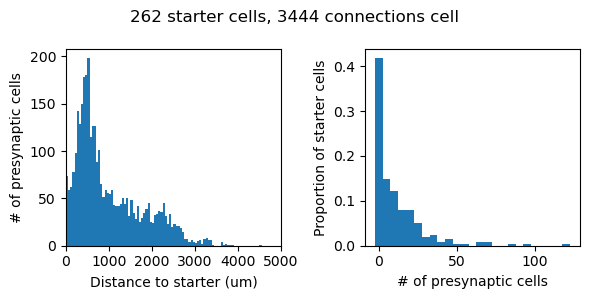

In [61]:
fig = plt.figure(figsize=(6,3))
fig.suptitle(f"{len(distances)} starter cells, {len(np.hstack(distances))} connections cell")
# _ = plt.hist(np.hstack(distances_same_z), bins =np.arange(0, 5000, 30), histtype='step', label='Same slice', density=True)
plt.subplot(121)
_ = plt.hist(np.hstack(distances), bins =np.arange(0, 5000, 50),  label='All slices', density=False)

plt.xlim([0, 5000])
plt.xlabel('Distance to starter (um)')
plt.ylabel('# of presynaptic cells')


ax= plt.subplot(122)

n_per = [len(d) for d in distances]
h, e =np.histogram(n_per, bins=np.arange(0,130,5))
ax.bar(e[:-1], h/h.sum(), width=5)
plt.xlabel('# of presynaptic cells')
plt.ylabel('Proportion of starter cells')

fig.tight_layout()
fig.savefig(target_folder / 'distance_distribution.pdf', bbox_inches='tight', dpi=300)
fig.savefig(target_folder / 'distance_distribution.png', bbox_inches='tight', dpi=300)

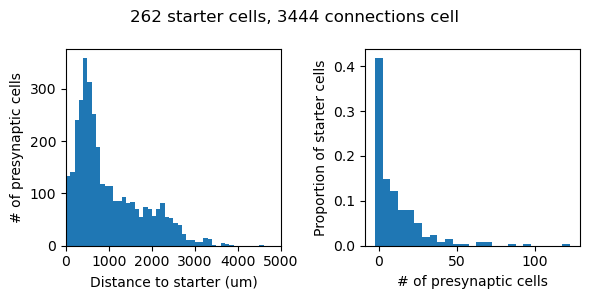

In [63]:
valid_starter = starter_properties[starter_properties.main_barcode.isin(valid_barcodes)].index
distances, distances_same_z = [], []
for starter in valid_starter:
    prop = rab_cells_properties.loc[starter]
    starter_coords = prop[['x_reg_um', 'y_reg_um', 'z_reg_um']].values.astype(float)

    barcode = prop.main_barcode
    presynaptic = rab_cells_barcodes[rab_cells_barcodes[barcode] > 5]
    presynaptic = presynaptic.drop(starter)
    presynaptic_coords = rab_cells_properties.loc[presynaptic.index, ['x_reg_um', 'y_reg_um', 'z_reg_um']].values.astype(float)
    
    same_z = presynaptic_coords[:,2] == starter_coords[2]
    distances_same_z.append(np.linalg.norm(starter_coords - presynaptic_coords[same_z], axis=1))
    distances.append(np.linalg.norm(starter_coords - presynaptic_coords, axis=1))
fig = plt.figure(figsize=(6,3))
fig.suptitle(f"{len(distances)} starter cells, {len(np.hstack(distances))} connections cell")
# _ = plt.hist(np.hstack(distances_same_z), bins =np.arange(0, 5000, 30), histtype='step', label='Same slice', density=True)
plt.subplot(121)
_ = plt.hist(np.hstack(distances), bins =np.arange(0, 5000, 100),  label='All slices', density=False)

plt.xlim([0, 5000])
plt.xlabel('Distance to starter (um)')
plt.ylabel('# of presynaptic cells')


ax= plt.subplot(122)

n_per = [len(d) for d in distances]
h, e =np.histogram(n_per, bins=np.arange(0,130,5))
ax.bar(e[:-1], h/h.sum(), width=5)
plt.xlabel('# of presynaptic cells')
plt.ylabel('Proportion of starter cells')

fig.tight_layout()
fig.savefig(target_folder / 'distance_distribution.pdf', bbox_inches='tight', dpi=300)
fig.savefig(target_folder / 'distance_distribution.png', bbox_inches='tight', dpi=300)

In [57]:
starter_properties.main_barcode.isin(valid_barcodes)

mask_uid
chamber_07_10_10939     True
chamber_07_10_10983     True
chamber_07_10_11525     True
chamber_07_10_11919     True
chamber_07_10_13598    False
                       ...  
chamber_08_9_7104      False
chamber_08_9_7176       True
chamber_08_9_7493      False
chamber_08_9_7507      False
chamber_08_9_9992      False
Name: main_barcode, Length: 444, dtype: bool

In [53]:
np.mean(n_per)

20.245495495495497